Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""
    m_examples = 100
    score_name = "quality"
    clean_up = False

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    define_Stan_reading_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_reading_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
m_train_examples: int = m_examples
m_test_examples: int = m_examples
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,1754,0,2,6425,0,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,0,1,6283,0,2,3610,0,3,2085,0,4,5610,1


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.45
1,pick_value_1,0.24
2,pick_value_2,0.17
3,pick_value_3,0.09
4,pick_value_4,0.05


In [18]:
# TODO: better estimate here
p_continue_est = np.mean( 
    (np.array(win_frequencies['win frequency'][range(1, win_frequencies.shape[0])]) + 1e-2)
 / (np.array(win_frequencies['win frequency'][range(0, win_frequencies.shape[0] - 1)]) + 1e-2)
)

p_continue_est

0.6047584541062802

In [19]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,1754,0,6425,0,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,0,6283,0,3610,0,2085,0,5610,1
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,0,1374,0,312,0,926,1,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [20]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [21]:
stan_model_reading_panel_src = define_Stan_reading_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_reading_panel_src)
data_reading_str = format_Stan_reading_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=p_continue_est,
)
fit_reading = run_stan_model(
    stan_model_src=stan_model_reading_panel_src,
    data_str=data_reading_str,
    model_note='reading_model',
    clean_up=clean_up,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of reading on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of it

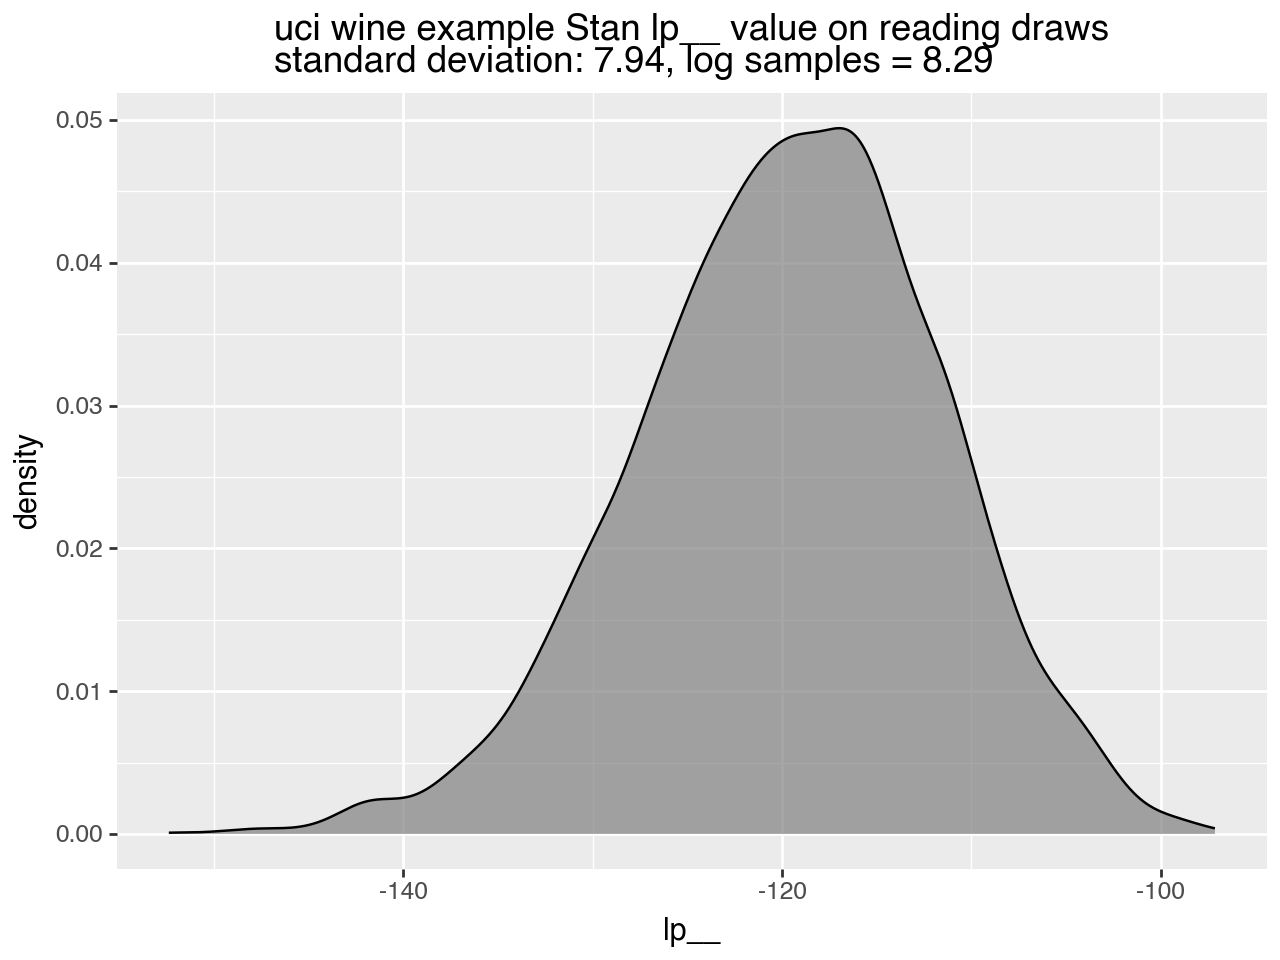

In [22]:
# get implied sample weights from chain
wt_frame = fit_reading.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on reading draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [23]:
beta_draws = fit_reading.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,-5.51941,-7.84708,-16.552100,1.445070,-0.364429,0.719403,-0.424567,-5.300240,8.21702,11.545800,...,1.246140,0.492571,-3.071420,0.113160,-0.081236,-18.13470,0.309590,15.40370,2.86915,-10.95720
1,-1.54216,-5.66342,-6.781800,-0.193484,7.513650,0.608803,-0.601669,-1.810990,3.66840,4.032960,...,4.016720,0.707055,1.679890,-0.182634,0.067938,-19.52560,9.292270,14.38620,6.21190,5.81620
2,2.35345,6.65983,9.506670,3.547860,-4.996300,1.859420,-0.983742,7.512900,4.34293,0.245005,...,3.849270,1.147010,-6.703560,0.082942,-0.093555,15.09410,-13.340600,-5.45295,8.26103,-5.63416
3,2.61946,1.37778,10.161300,-3.762280,-0.421347,1.141410,-0.870741,-0.899156,9.34620,5.861950,...,-0.712391,0.434724,4.286920,0.077410,0.002767,23.15840,-8.330510,-16.75730,6.88148,-9.84628
4,-5.25226,2.89346,11.473400,-2.528030,0.826270,0.656051,-0.907840,4.355250,13.25590,-4.612560,...,-8.984040,-0.029711,18.833500,-0.091332,0.022672,23.71230,2.362470,14.11630,6.38622,-1.94333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-3.25965,2.93061,4.095310,0.596640,-3.921580,1.481220,-0.996281,12.648000,11.46770,5.656330,...,-0.338333,0.133952,0.495965,-0.129549,0.069507,6.67959,-1.515000,1.64867,8.87682,3.41772
3996,-3.78589,-4.67201,0.022416,1.108410,-6.466070,1.534430,-1.115540,11.668600,5.85725,10.476900,...,2.476490,0.367205,-2.483560,-0.182528,0.114824,10.47360,-4.588790,2.39955,7.58350,13.50640
3997,1.57725,4.73312,-7.443540,4.563440,8.490860,0.131575,-0.223183,-21.501800,-3.34308,-0.967838,...,2.722680,1.101670,8.751820,0.187654,-0.069361,-1.67282,0.534671,11.11210,4.76782,-5.25129
3998,-2.90610,1.56743,-4.828800,-1.333550,-9.330420,0.589652,-0.437015,25.665600,4.06873,0.737257,...,-0.891583,0.559083,-14.915600,-0.058557,0.004911,2.29325,-8.617160,4.41866,7.30880,8.28427


In [24]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_reading_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
estimated_beta_reading_Stan

fixed acidity is red            -1.860581
volatile acidity is red         -0.457033
citric acid is red              -1.675742
residual sugar is red            0.722682
chlorides is red                -0.191574
free sulfur dioxide is red       0.891075
total sulfur dioxide is red     -0.614700
density is red                   0.701794
pH is red                        5.830053
sulphates is red                -0.469380
alcohol is red                   4.330288
fixed acidity is white          -1.915657
volatile acidity is white       -4.774252
citric acid is white             0.466262
residual sugar is white          0.715981
chlorides is white               0.367565
free sulfur dioxide is white     0.050702
total sulfur dioxide is white   -0.055304
density is white                -0.672191
pH is white                     -0.392856
sulphates is white               3.780443
alcohol is white                 6.064740
is_red                           1.122596
dtype: float64

In [25]:
estimated_beta_reading_Stan = list(estimated_beta_reading_Stan) + [0] * n_alternatives  # TODO: clean

picks


/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,row,position,pick probability estimate,was pick
0,0,0,0.6394,False
1,0,1,0.0415,False
2,0,2,0.1266,True
3,0,3,0.0628,False
4,0,4,0.1297,False
5,1,0,0.0328,False
6,1,1,0.3156,True
7,1,2,0.3167,False
8,1,3,0.2876,False
9,1,4,0.0473,False


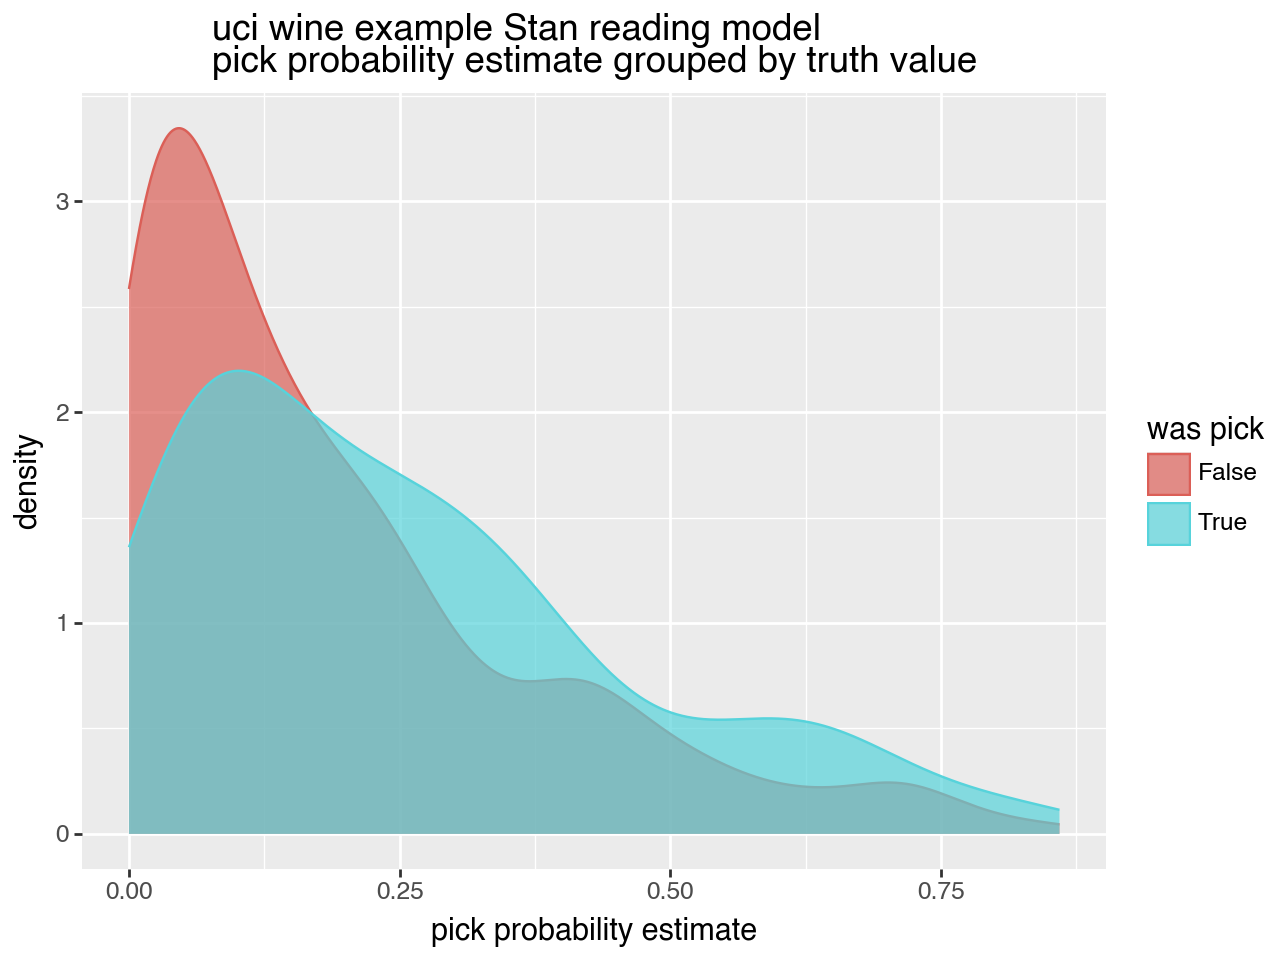

<Figure size 640x480 with 0 Axes>

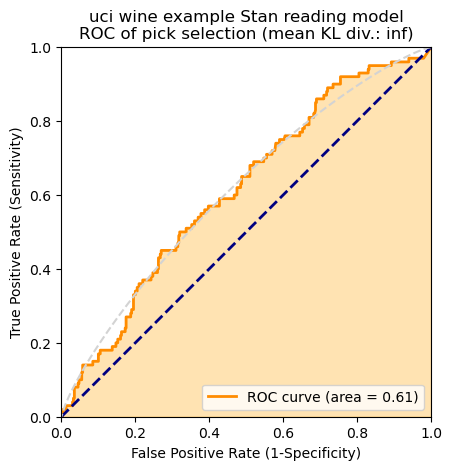

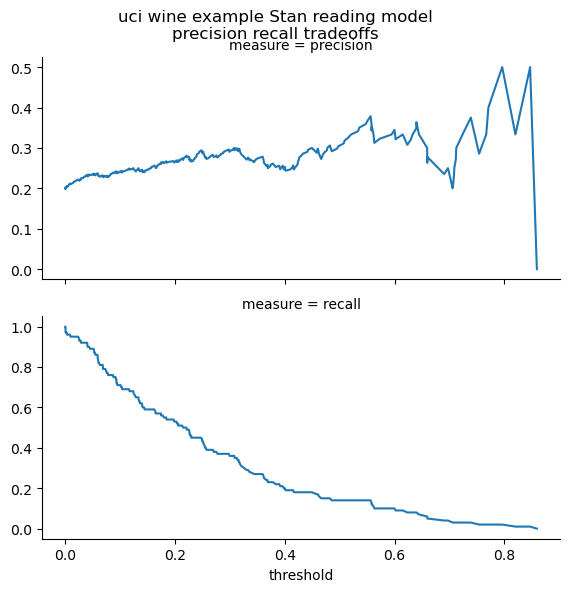

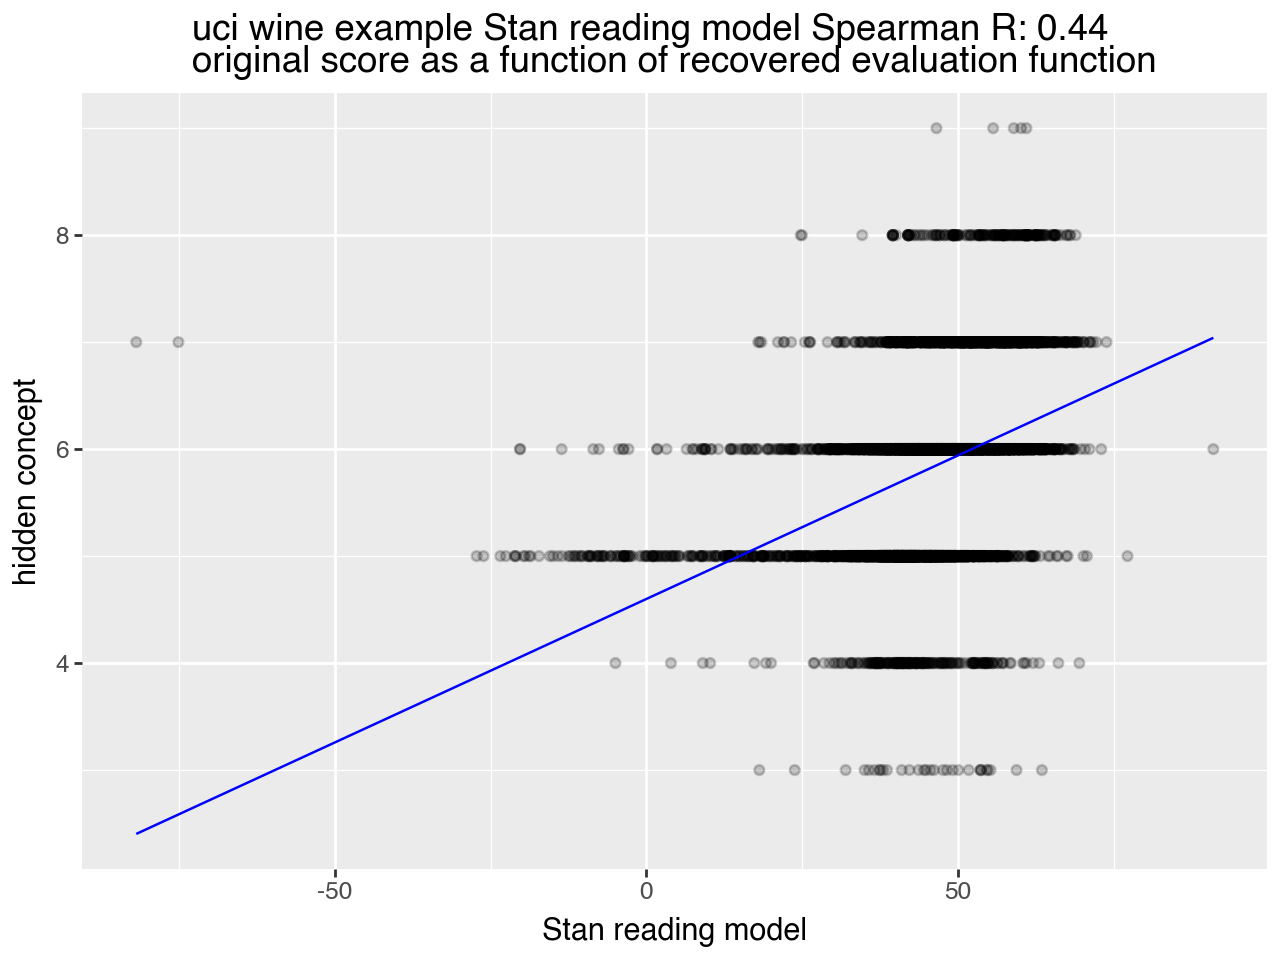

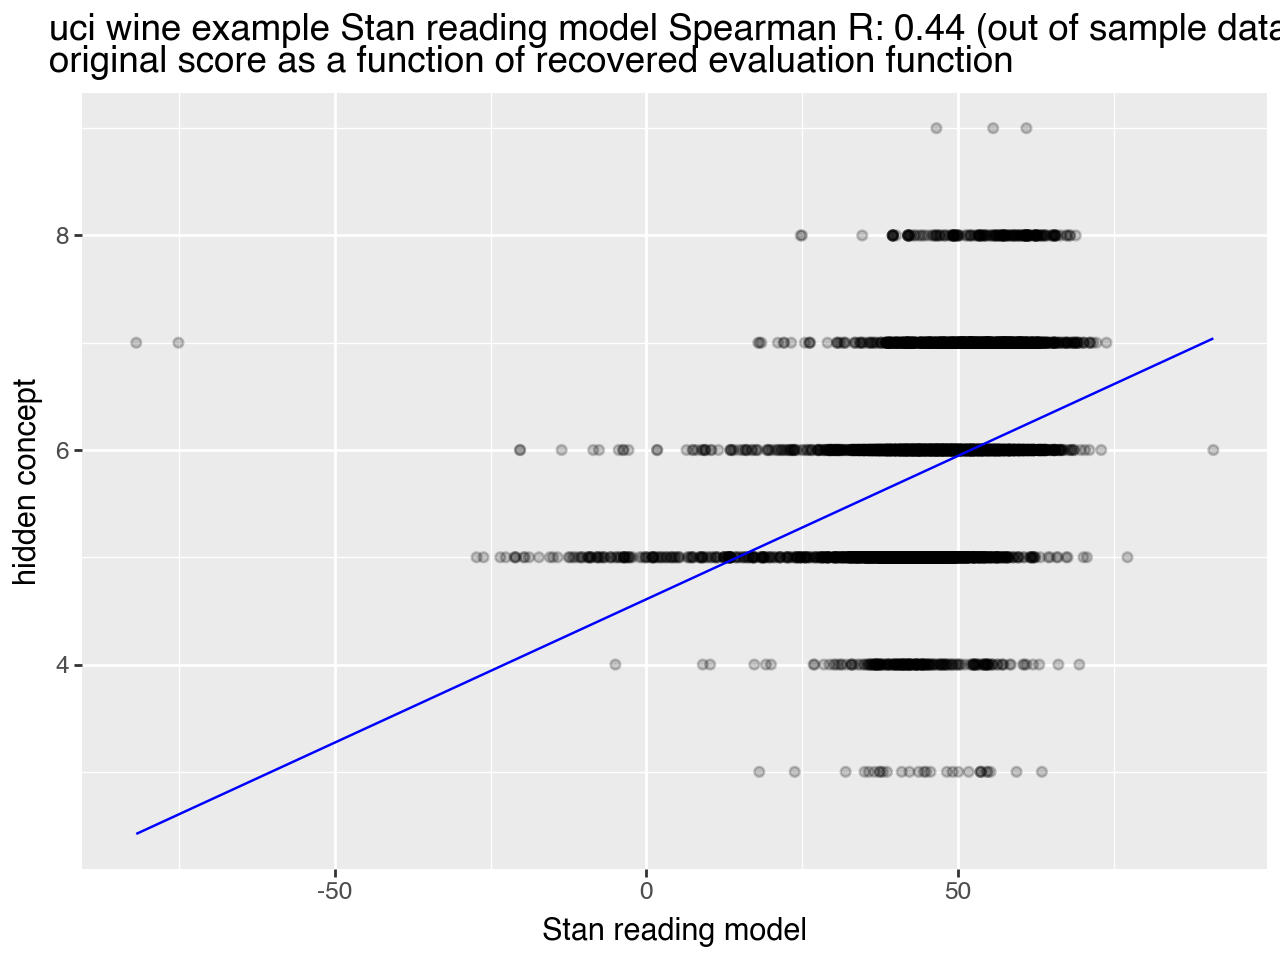

In [26]:
stat_pull_reading_Stan = plot_rank_performance(
    model=estimated_beta_reading_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan reading model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_reading_Stan)

Try a Stan model with position choice modeled as utility.

In [27]:
observations_sorted_train = sort_observations_frame(observations_train)

In [28]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_panel_src)
data_str = format_Stan_data(
    observations_sorted=observations_sorted_train,
    features_frame=features_frame,
)
fit_utility_Stan = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
    model_note='utility_model',
    clean_up=clean_up,
)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [29]:
beta_draws_utility = fit_utility_Stan.draws_pd(vars=["beta"])
beta_draws_utility_display = beta_draws_utility.copy()
beta_draws_utility_display.columns = list(features_frame.columns) + [
    f'position_{sel_j}' for sel_j in range(n_alternatives)
]

beta_draws_utility_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_0,position_1,position_2,position_3,position_4
0,0.882089,-8.10106,5.639370,-5.290080,-1.062570,0.313798,-0.235341,-1.23613,10.579700,-8.42055,...,5.56884,-6.344810,6.64562,3.01424,-5.652670,-1.00438,-3.819910,-8.178600,-11.51010,-14.63880
1,0.509913,-7.35718,-4.811380,0.563813,-3.946660,0.453714,-0.220247,-4.27264,17.490400,-7.27150,...,-3.67333,8.455310,7.44938,2.04930,6.794800,7.85983,2.562930,0.214217,-2.83810,-9.27183
2,-2.507270,-1.53178,21.799800,-2.856140,0.886149,0.108432,-0.221130,10.50820,-1.993210,-5.79884,...,-4.49757,-5.777440,7.09630,1.46128,-0.823513,3.24135,1.433340,-5.632920,-9.22782,-12.16060
3,1.068640,-2.48509,-0.649719,-0.928980,-4.613840,-0.053891,-0.043675,5.67829,12.377700,-2.78725,...,17.18280,6.760320,1.33464,2.78641,1.481750,11.41530,2.960080,2.419460,-5.31635,-6.66955
4,1.242340,-16.63830,-2.190530,-2.570740,-6.020690,0.128928,-0.076534,-16.47830,-2.502700,-3.61977,...,-2.00058,-2.432690,5.73849,2.02628,5.076550,11.43210,7.347590,5.923690,-2.21018,-4.39753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.868750,-5.17445,-2.129290,-2.418540,-1.666820,0.748342,-0.181662,21.75890,0.984589,-10.34700,...,-12.46100,1.957650,17.58390,4.22123,4.067500,15.38390,4.453970,3.756330,-1.14801,-6.11832
3996,-1.670300,-4.37266,-0.672888,-0.093213,0.437171,0.171307,-0.147487,-13.24170,9.671830,-2.77348,...,7.44702,-0.365573,-1.79460,0.68378,-2.422090,5.77273,0.374358,-2.668380,-3.97511,-5.72734
3997,1.924240,-2.98296,10.801500,-2.114120,3.723860,0.314389,-0.150450,4.03208,3.221470,-3.85121,...,-16.22250,3.647860,9.81069,3.05903,4.080640,12.21980,1.764790,1.142150,-4.60573,-5.68845
3998,-0.496130,-1.93331,-1.828360,-1.533730,-19.604400,-0.348898,-0.134436,-3.33473,4.012010,-9.84893,...,4.92471,0.176488,-5.39306,1.20844,-2.846240,9.30186,6.068960,1.516010,2.98024,-5.72931


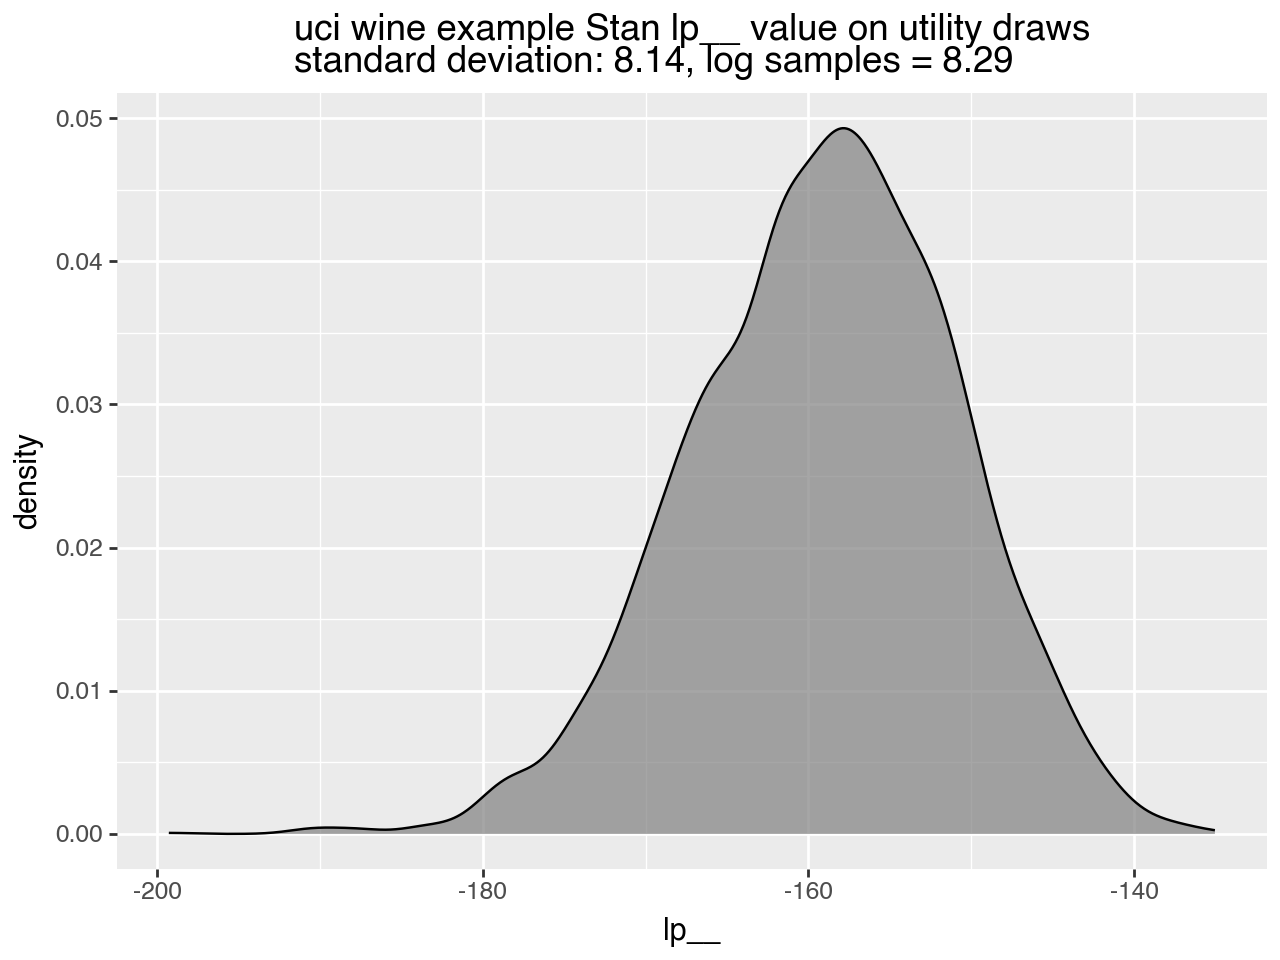

In [30]:
# get implied sample weights from chain
wt_frame_utility = fit_utility_Stan.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_utility["lp__"]))
    log_samples = np.log(wt_frame_utility.shape[0])
    (
        ggplot(
            data=wt_frame_utility,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on utility draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [31]:
estimated_beta_utility_Stan = beta_draws_utility_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame_utility["lp__"], 0.5), :
].mean()
estimated_beta_utility_Stan

fixed acidity is red             0.199273
volatile acidity is red         -4.119478
citric acid is red               3.259998
residual sugar is red           -0.930104
chlorides is red                -1.841459
free sulfur dioxide is red       0.266658
total sulfur dioxide is red     -0.175409
density is red                   1.030698
pH is red                        4.940866
sulphates is red                -5.162851
alcohol is red                   0.749247
fixed acidity is white          -1.372398
volatile acidity is white       -9.876251
citric acid is white            -2.862971
residual sugar is white          0.563143
chlorides is white               0.778225
free sulfur dioxide is white    -0.044362
total sulfur dioxide is white   -0.001871
density is white                -1.172943
pH is white                      0.684878
sulphates is white               5.722892
alcohol is white                 2.474910
is_red                           1.290606
position_0                       8

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6193,False
1,0,1,0.1731,False
2,0,2,0.1426,True
3,0,3,0.0333,False
4,0,4,0.0317,False
5,1,0,0.3252,False
6,1,1,0.3695,True
7,1,2,0.2119,False
8,1,3,0.0627,False
9,1,4,0.0307,False


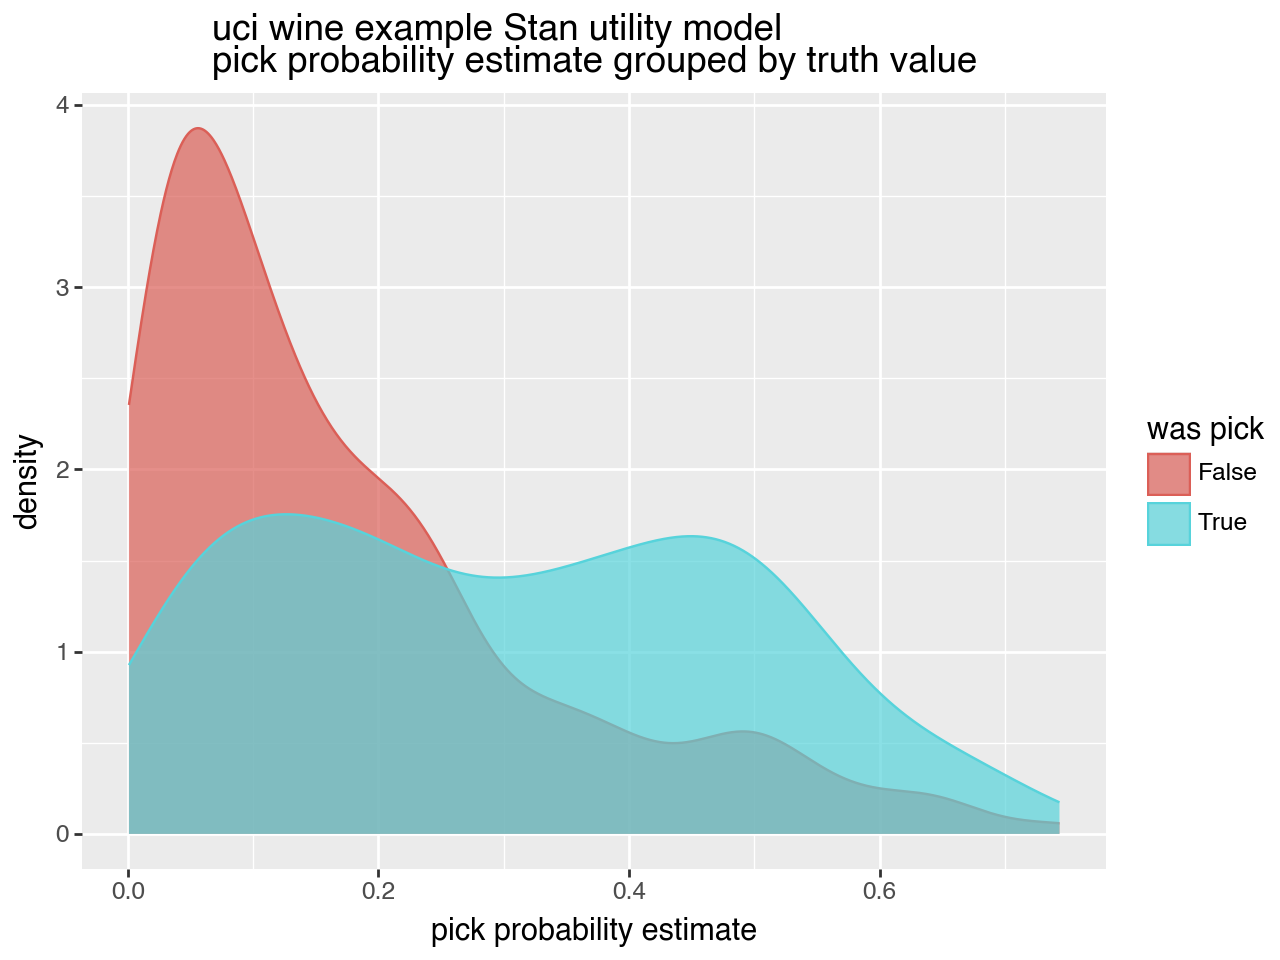

<Figure size 640x480 with 0 Axes>

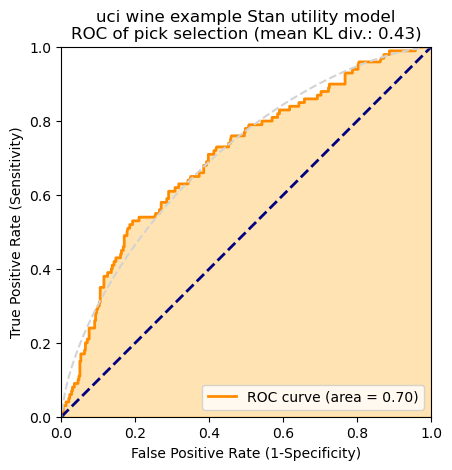

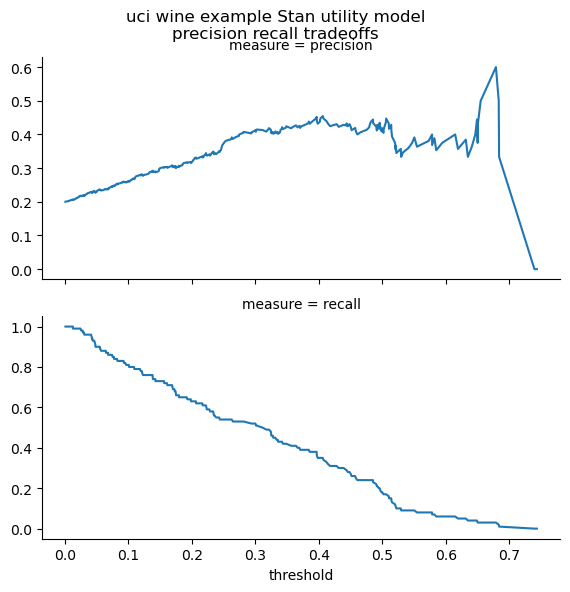

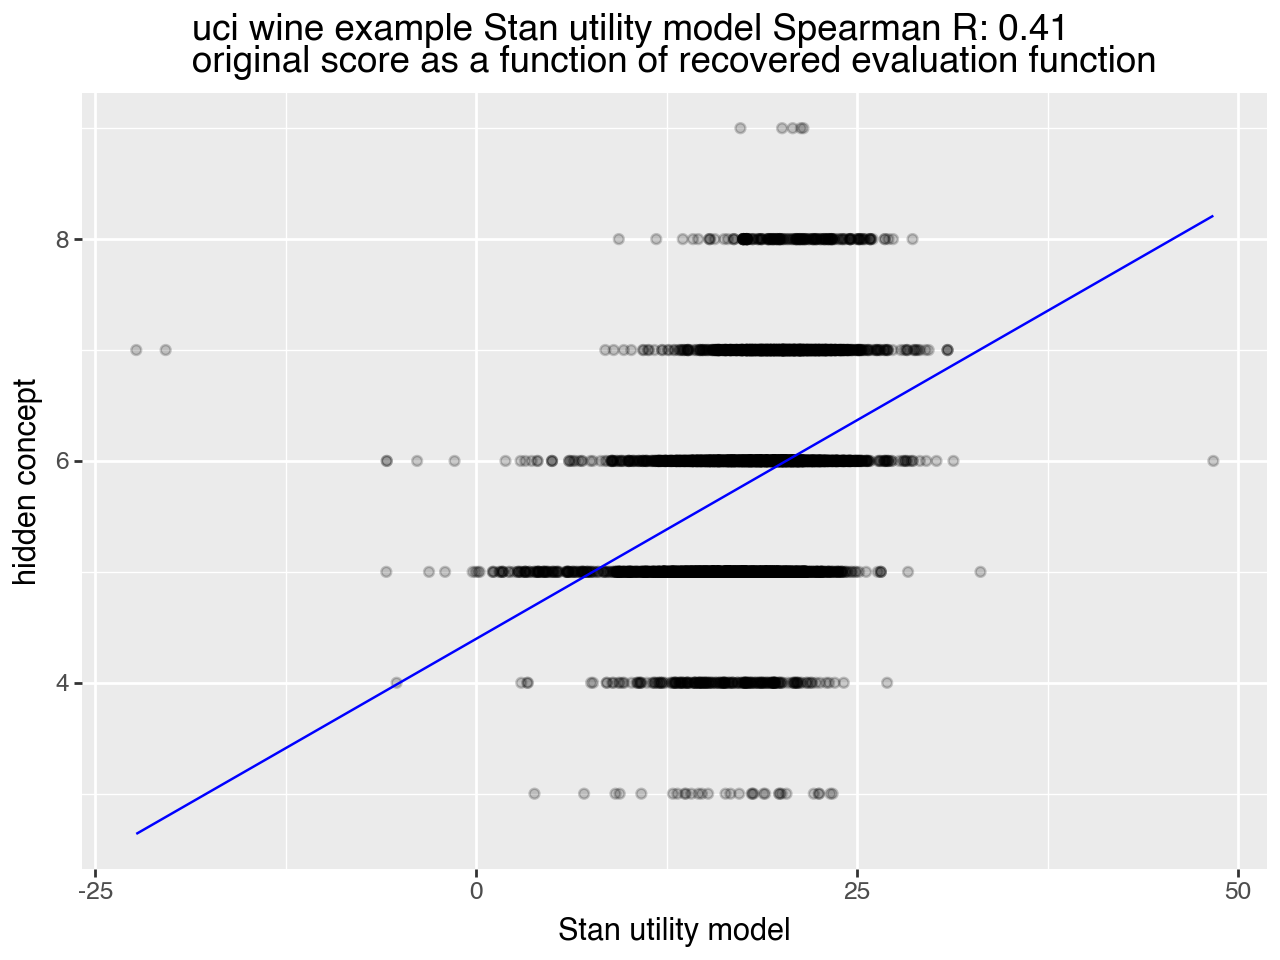

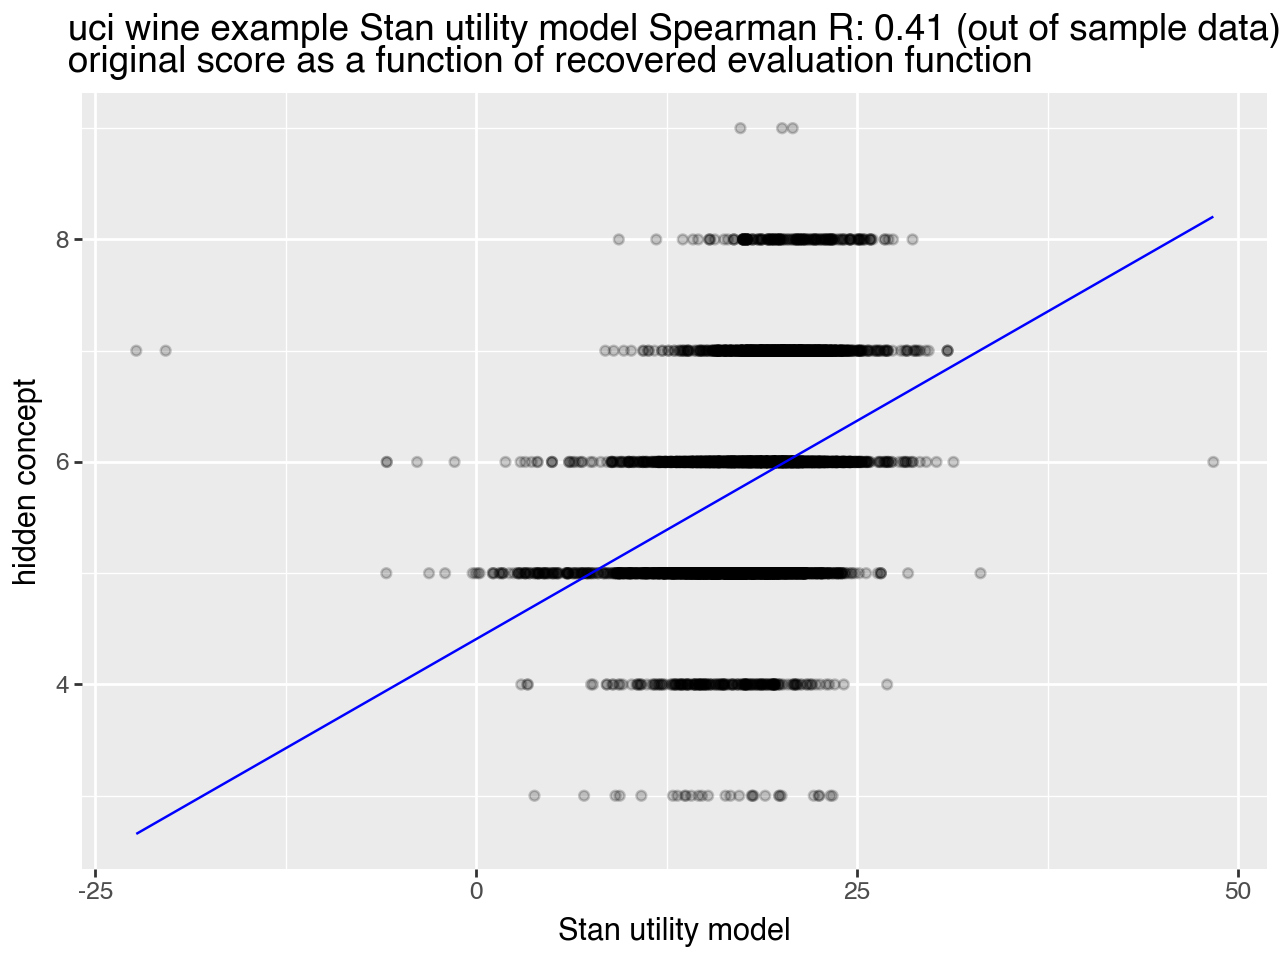

In [32]:
stat_pull_Stan = plot_rank_performance(
    model=estimated_beta_utility_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan utility model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_Stan)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [33]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [34]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [35]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2451,False
1,0,1,0.2146,False
2,0,2,0.2043,True
3,0,3,0.1709,False
4,0,4,0.1651,False
5,1,0,0.2227,False
6,1,1,0.2332,True
7,1,2,0.2033,False
8,1,3,0.1762,False
9,1,4,0.1646,False


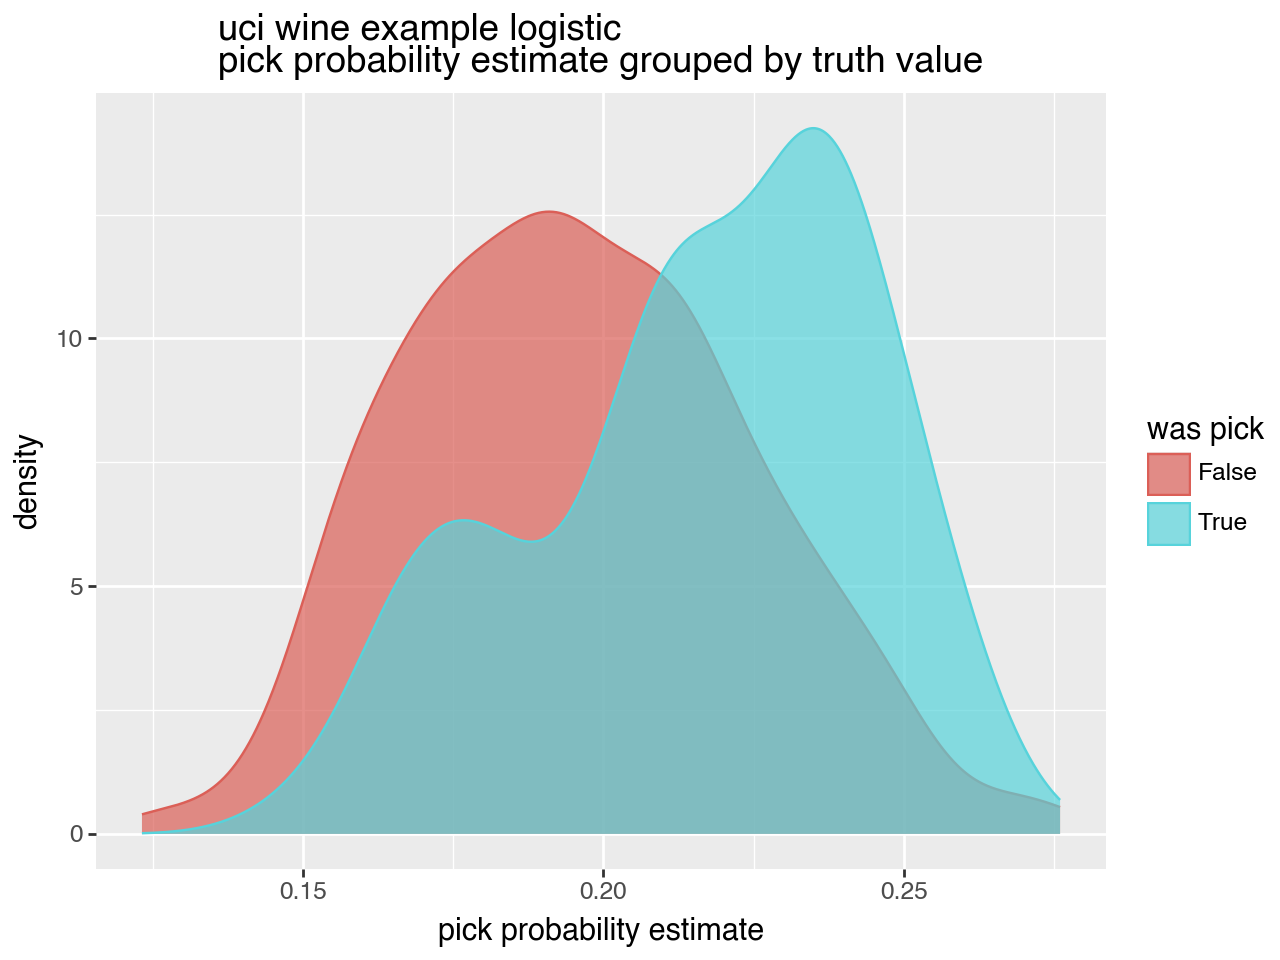

<Figure size 640x480 with 0 Axes>

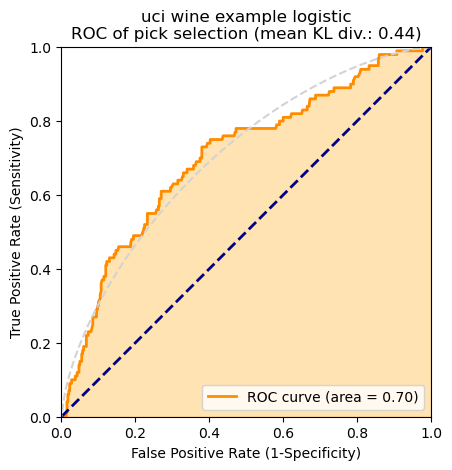

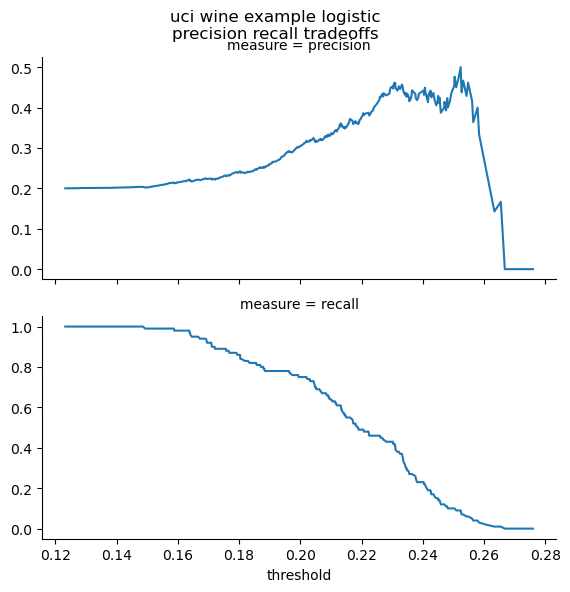

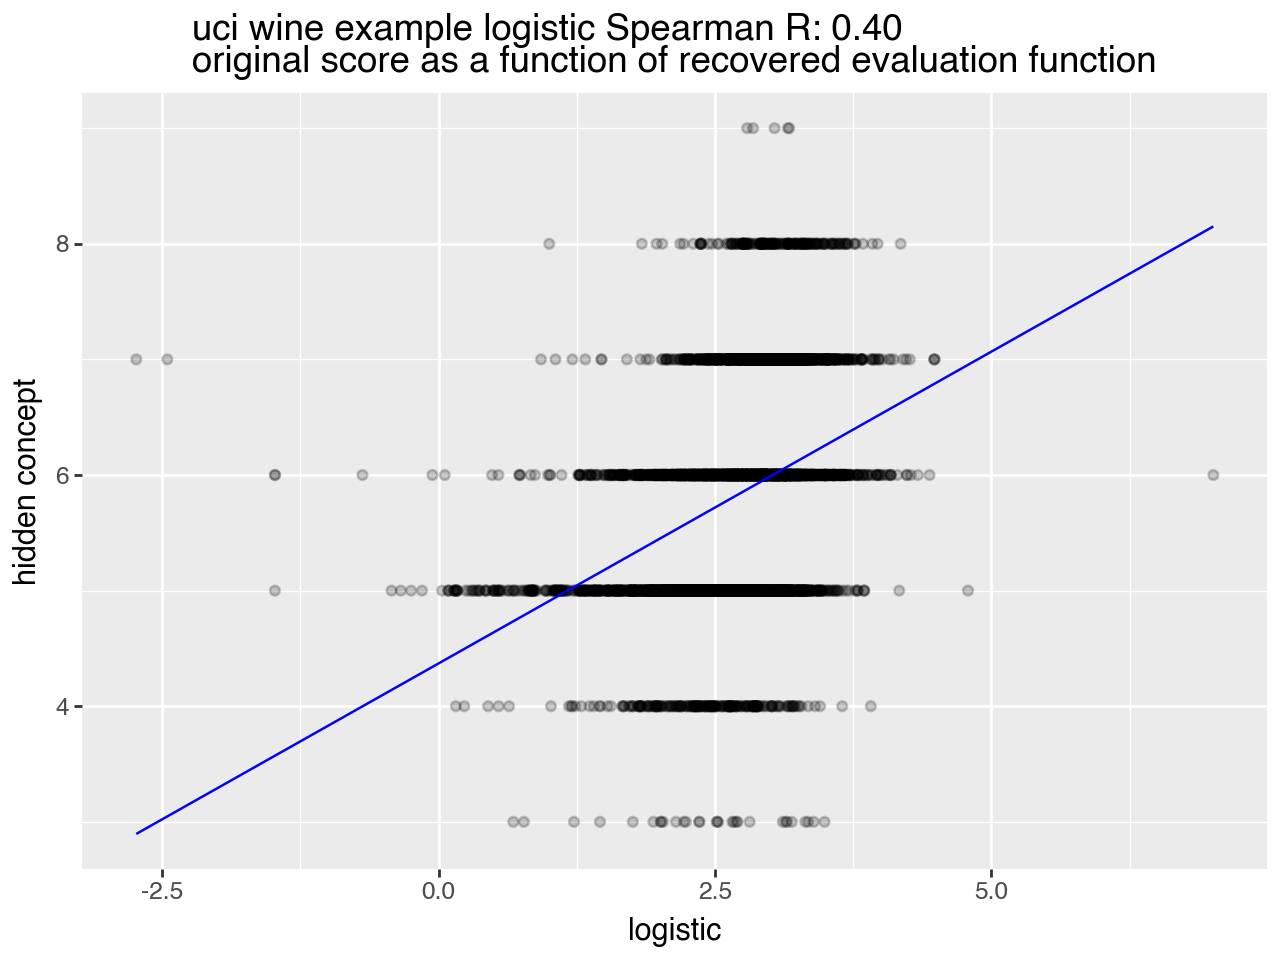

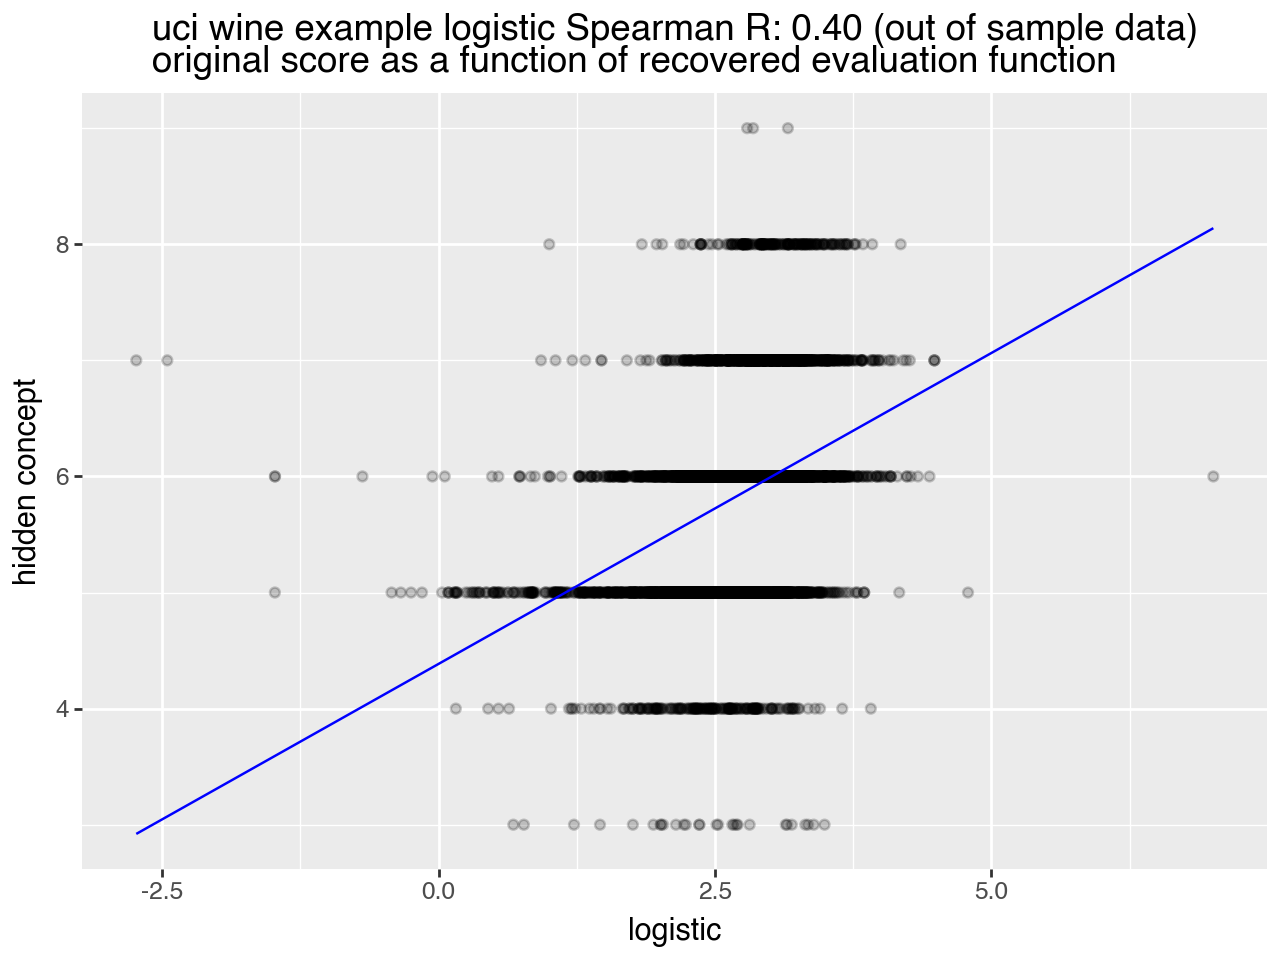

In [36]:
stat_pull_classifier = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_classifier)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2107,False
1,0,1,0.1969,False
2,0,2,0.2126,True
3,0,3,0.1951,False
4,0,4,0.1847,False
5,1,0,0.1908,False
6,1,1,0.2103,True
7,1,2,0.2092,False
8,1,3,0.1998,False
9,1,4,0.1899,False


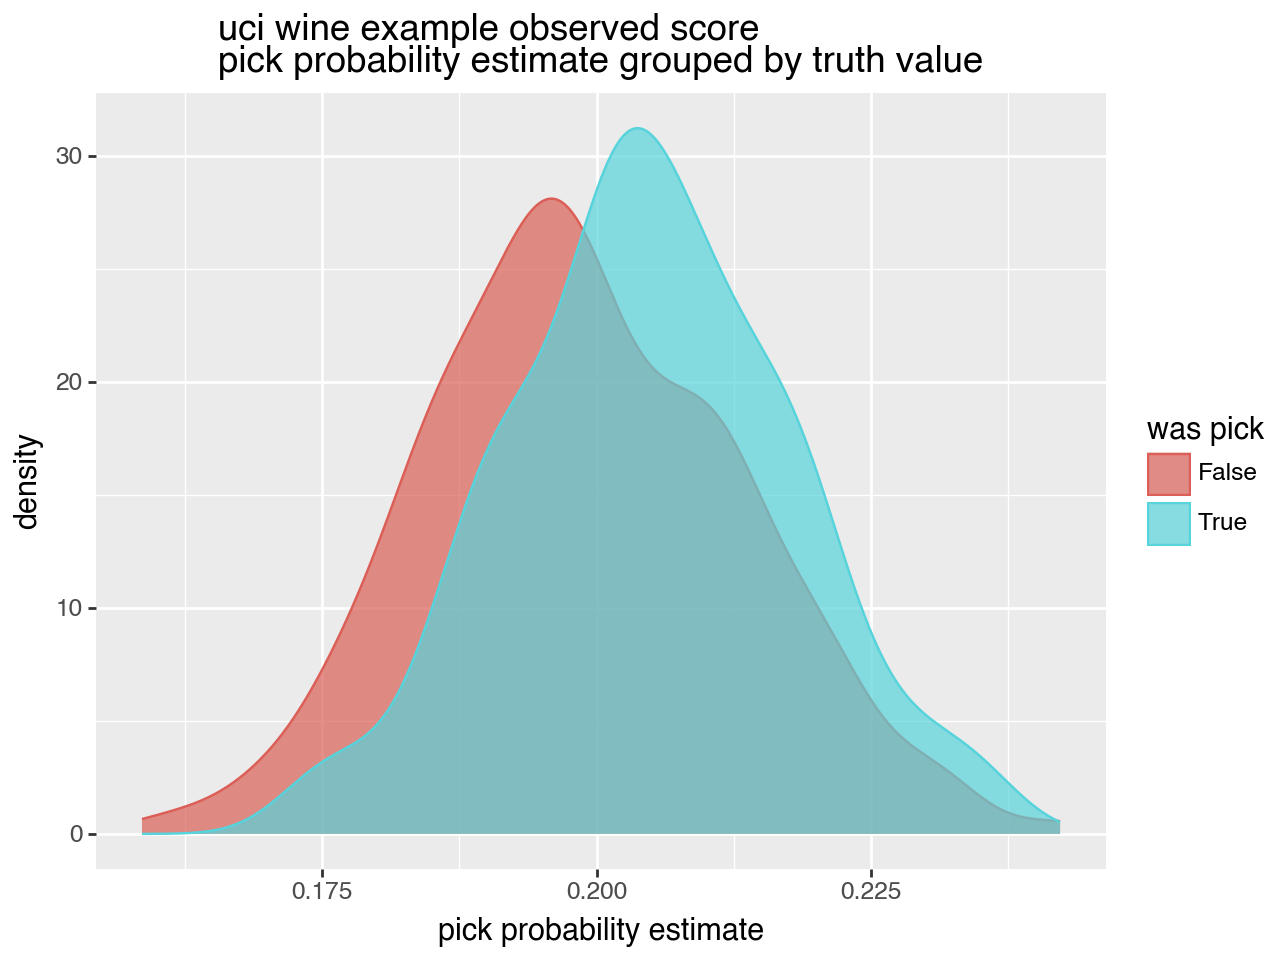

<Figure size 640x480 with 0 Axes>

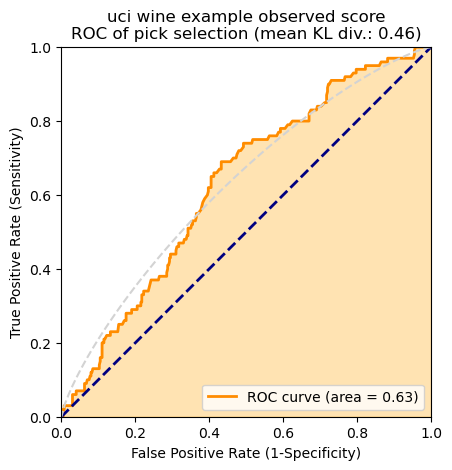

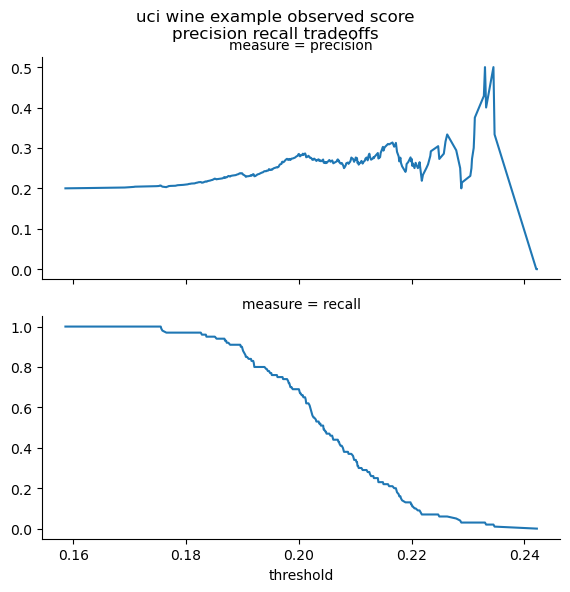

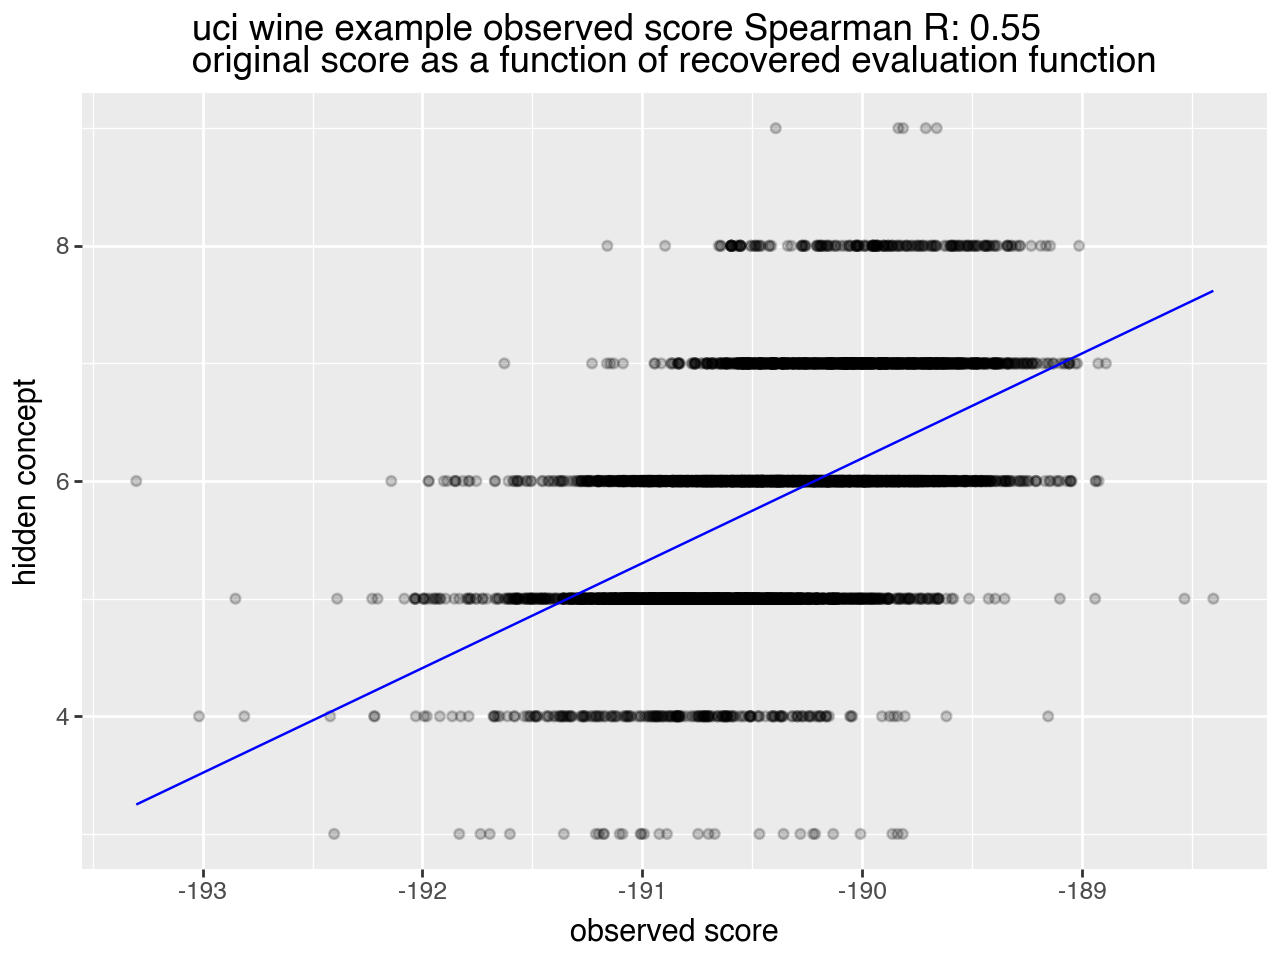

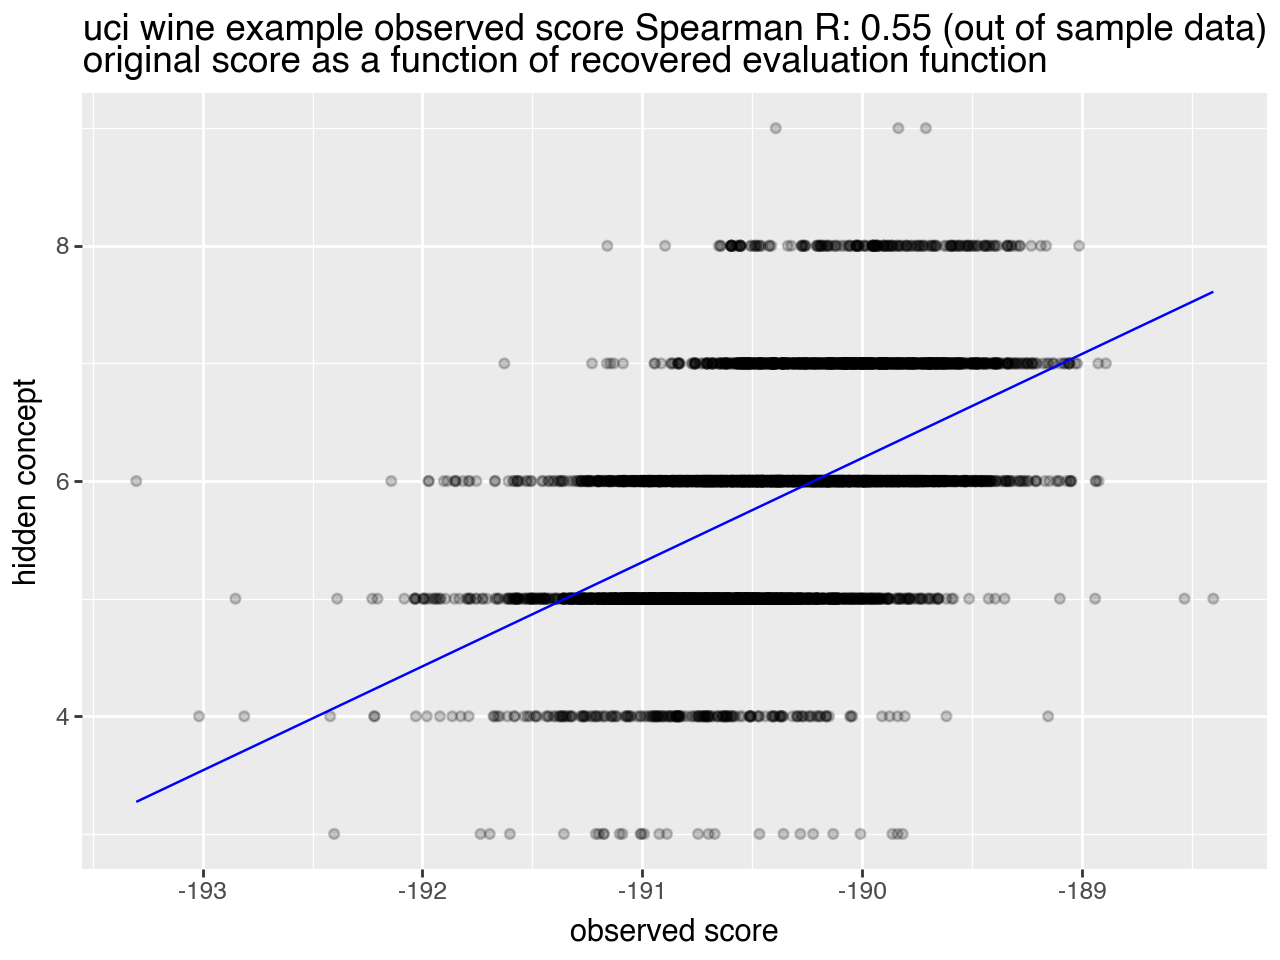

In [37]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [38]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [39]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [40]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan reading model,0.444215,0.441607,0.612200,inf,100,100,6497,6013
1,uci wine example,Stan utility model,0.407490,0.406454,0.703013,0.430983,100,100,6497,6013
2,uci wine example,logistic,0.401345,0.399807,0.702450,0.444034,100,100,6497,6013
3,uci wine example,observed score,0.551482,0.549029,0.627475,0.458029,100,100,6497,6013
